# cesm Rainfall by Event Type

This file makes lots of contour plots for rainfall and temperature anomalies under different individal and compound event types

It relies on the output from 'cesmPrecTsMonthly.ipynb' and 'cesmCompounds.ipynb'

In [1]:
#import my functions
import utils._modelDefinitions as _model


In [2]:
import xarray
import numpy

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import scipy.stats

%matplotlib inline

# Import Events

In [3]:
firePos=xarray.open_dataset('results/cesmFirePos.nc').sel(experiment=_model.cesmNoRepeats)
fireNeg=xarray.open_dataset('results/cesmFireNeg.nc').sel(experiment=_model.cesmNoRepeats)


And import warm season rainfall

In [4]:
rainfallXr = xarray.open_dataset('results/cesmPrecAnoms.nc').sel(experiment=_model.cesmNoRepeats)
tempXr = xarray.open_dataset('results/cesmTsAnoms.nc').sel(experiment=_model.cesmNoRepeats)

# Some functions

This function plots an contour map anomaly using a provided xarray object and an axis.

In [5]:
def plotAnom(da, ax):

    #set contour intervals and colours
    #rainfall
    if da.name=='precAnom':
        precContours=numpy.arange(-2.2,2.21,0.4)
        cmap='BrBG'
    #temp
    elif da.name=='tsAnom':
        precContours=numpy.arange(-3.25,3.26,0.5)
        cmap='coolwarm'
    
    #do the plotting
    cs=plt.contourf(da.lon, da.lat, da.values, precContours, 
                    transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    ax.coastlines(color='black')
    
    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels=False
    gl.left_labels=False
    
        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)
    
    #rainfall
    if da.name=='precAnom':
        cbar.set_label('Warm Season Anomaly (mm/day)')
    #temp
    elif da.name=='tsAnom':
        cbar.set_label('Warm Season Anomaly(C)')
    


This function loops though all the provides indeces and plots them for the date ranges 850-1850, 1850-2005 and 2005-2100

In [6]:
def multiPlotter(da, mask, indeces, filename):
    
    years=[850,1850,2005,2100]
    #Decide how many rows we are going to have
    lenYears=3

     
    lenIndeces=len(indeces)
    
    fig = plt.figure(figsize=(10*lenIndeces,8*lenYears))
    
    #for each row
    for iGroup in range(0,lenYears):

        #for each column
        for i in range(0,lenIndeces):
            
            #make a sub plot
            ax=fig.add_subplot(lenYears, #how many columns
                       lenIndeces, #how many rows
                       i+1+iGroup*lenIndeces, # index
                       projection=ccrs.Miller())
              #years to plot
            plotCond = mask[indeces[i]].sel(year=slice(years[iGroup],years[iGroup+1]))
            
            toPlot=da.where(plotCond).mean(['year','experiment'])

            #This is the number of events. Because dataset is well-curated, we can use the count from one position to be the count for everything
            nEvents=da.where(plotCond).isel(lon=0,lat=0).count().values
            
            plotAnom(toPlot, ax)

            ax.text(0.01,0.01,"n="+str(nEvents), transform=ax.transAxes, fontsize=22)
                            
            #in the first column, put a y-label
            if i==0:
                ax.text(-0.1, 0.5,  #xy relative to bottom left of axis
                        str(years[iGroup])+'-'+str(years[iGroup+1]), #yearRange
                        rotation='vertical', transform=ax.transAxes, 
                        verticalalignment='center', fontsize=30)
            
            #in the first row put a heading
            if iGroup ==0 :
                ax.set_title('Mean ' + da.name +' anomoly with ' + indeces[i] + ' event',
                             fontsize=22)
                
    plt.savefig(filename)
    plt.show()

In [7]:
def diffPlotter(da, mask, indeces, filename):
    
    years=[850,1850,2005,2100]

    lenIndeces=len(indeces)
    
    fig = plt.figure(figsize=(10*lenIndeces,8))
    
    #for each column
    for i in range(0,lenIndeces):
            
        #make a sub plot
        ax=fig.add_subplot(1, #how many rows
                   lenIndeces, #how many columns
                   i+1, # index
                   projection=ccrs.Miller(central_longitude=120))
          #years to plot
        plotCond1 = mask[indeces[i]].sel(year=slice(years[0],years[1]))
        plotCond2 = mask[indeces[i]].sel(year=slice(years[2],years[3]))

        toPlot=da.where(plotCond2).mean(['year','experiment']) - da.where(plotCond1).mean(['year','experiment'])

        plotAnom(toPlot, ax)

        #in the first column, put a y-label
        if i==0:
            ax.text(-0.1, 0.5,  #xy relative to bottom left of axis
                    "Difference between 2005-2100 and 850-1850 means", #yearRange
                    rotation='vertical', transform=ax.transAxes, 
                    verticalalignment='center', fontsize=30)

        ax.set_title('Difference in Mean ' + da.name +' Anomoly With ' + indeces[i] + ' Event',
                         fontsize=22)

    plt.savefig(filename)
    plt.show()

# Rainfall for fire-pos individual events

Mean rainfall anomaly for all models with one event

In [8]:
#Everything
everythingXr=(firePos.nEvents<5)
everythingXr.name='everything'

#The no firePos event
noEventXr=(firePos.nEvents==0)
noEventXr.name='noFirePos'

#the absence of events
nothingXr=noEventXr&(fireNeg.nEvents==0)
nothingXr.name='no'

#The single index only event
singleEventsXr=(firePos[firePos.indeces]==True)

#The compound events
compoundEventsXr=(firePos[[*firePos.pairs, 'all3']]==True)

#Put all those events in one xr
maskXr=xarray.merge([everythingXr, #nothingXr, noEventXr,
                     singleEventsXr, compoundEventsXr])

#List of events to plot
eventsList=['everything',#'no', 'noFirePos', 
            *firePos.indeces, *firePos.pairs, 'all3']

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


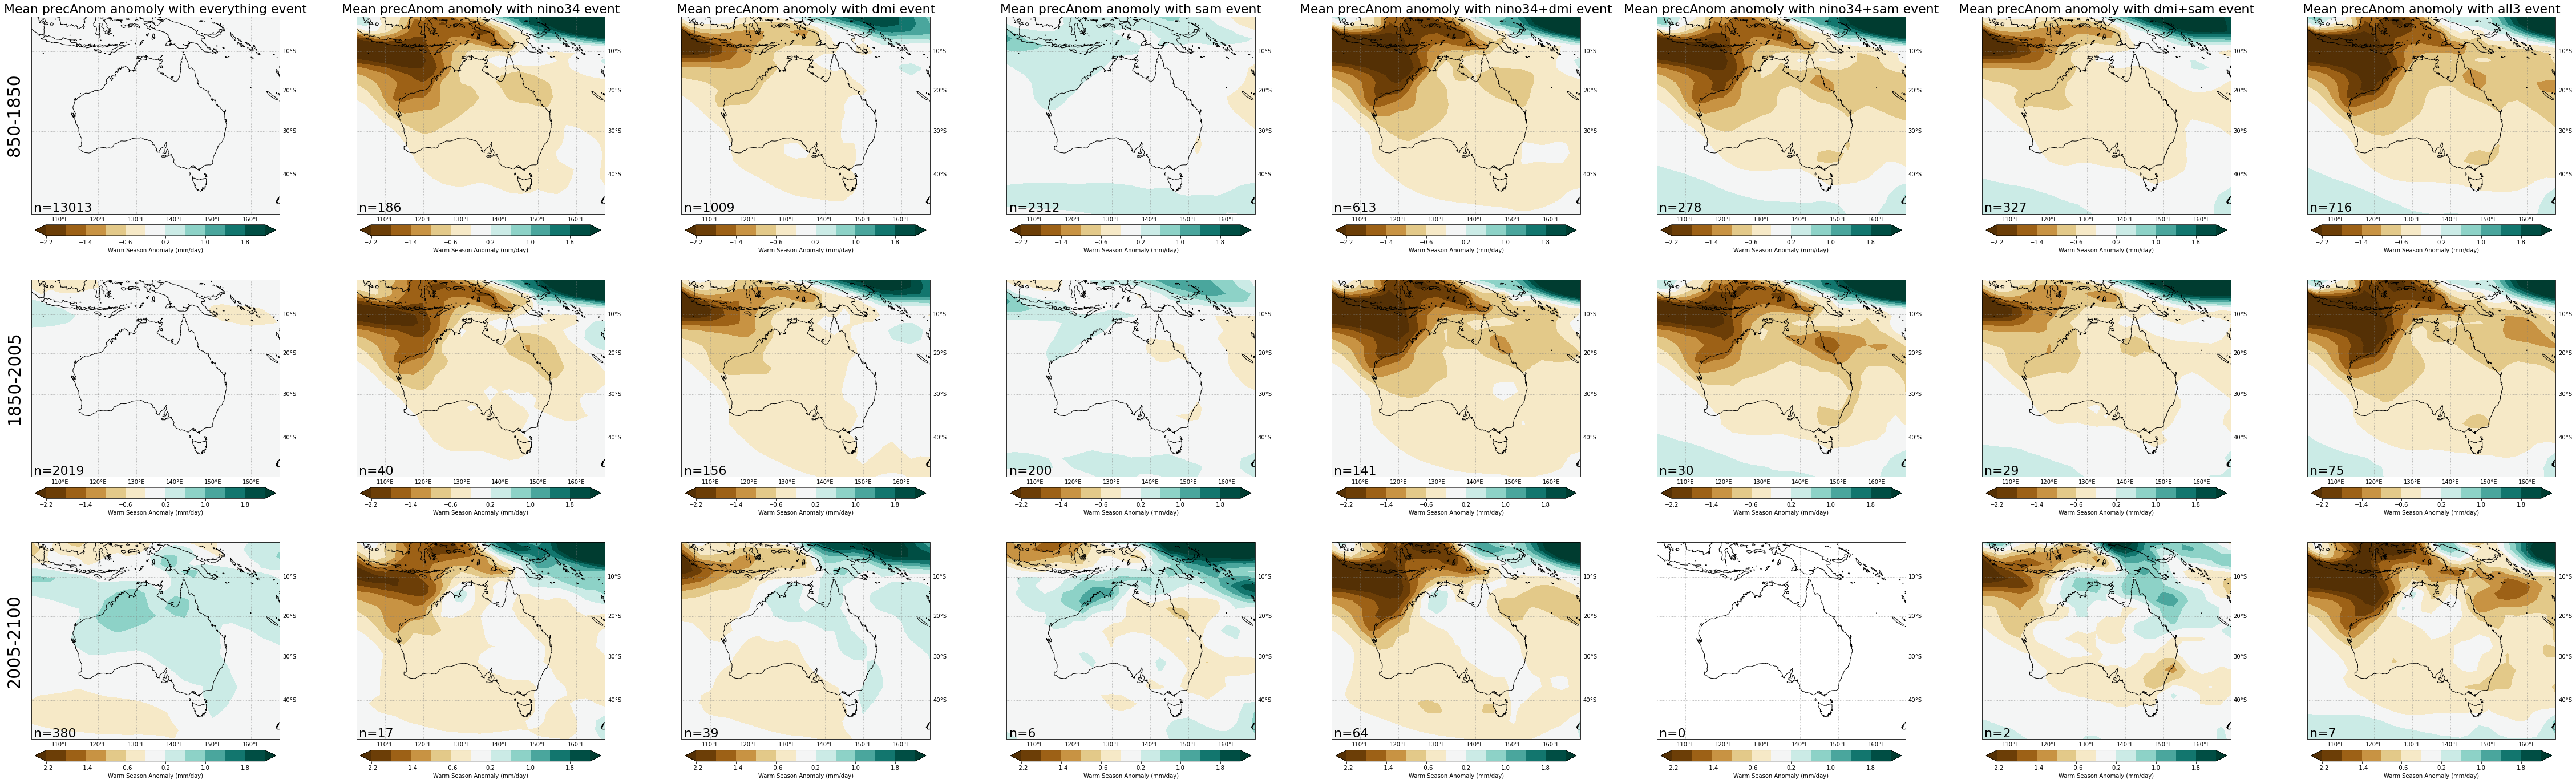

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


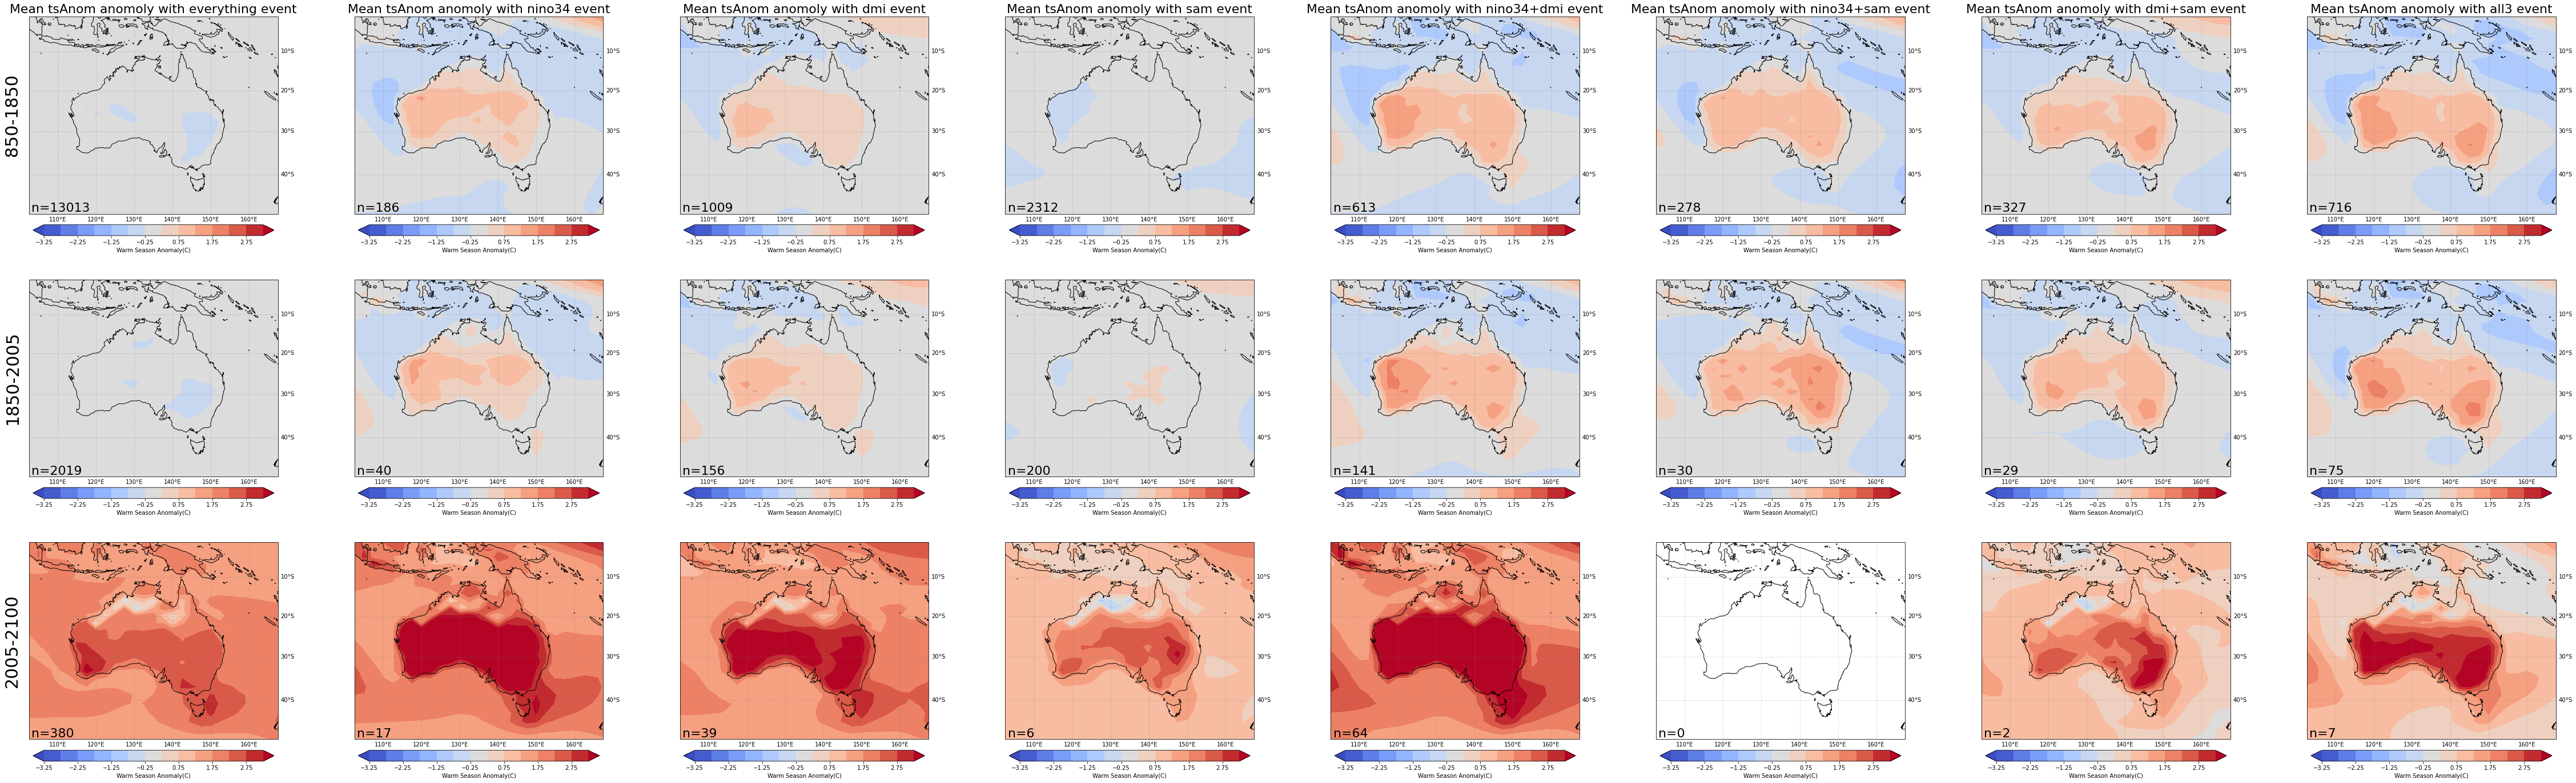

In [9]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr.precAnom, 
    maskXr, 
    eventsList,
    'results/cesmImpactFigures/firePosPrec.png'
)


multiPlotter(
    tempXr.tsAnom, 
    maskXr, 
    eventsList, 
    'results/cesmImpactFigures/firePosTemp.png'
)

Do the differences over time

diffPlotter(
    rainfallXr.precAnom, 
    maskXr, 
    eventsList,
    'results/cesmImpactFigures/firePosPrecDiff.png'
)


diffPlotter(
    tempXr.tsAnom, 
    maskXr, 
    eventsList, 
    'results/cesmImpactFigures/firePosTempDiff.png'
)

And detrended

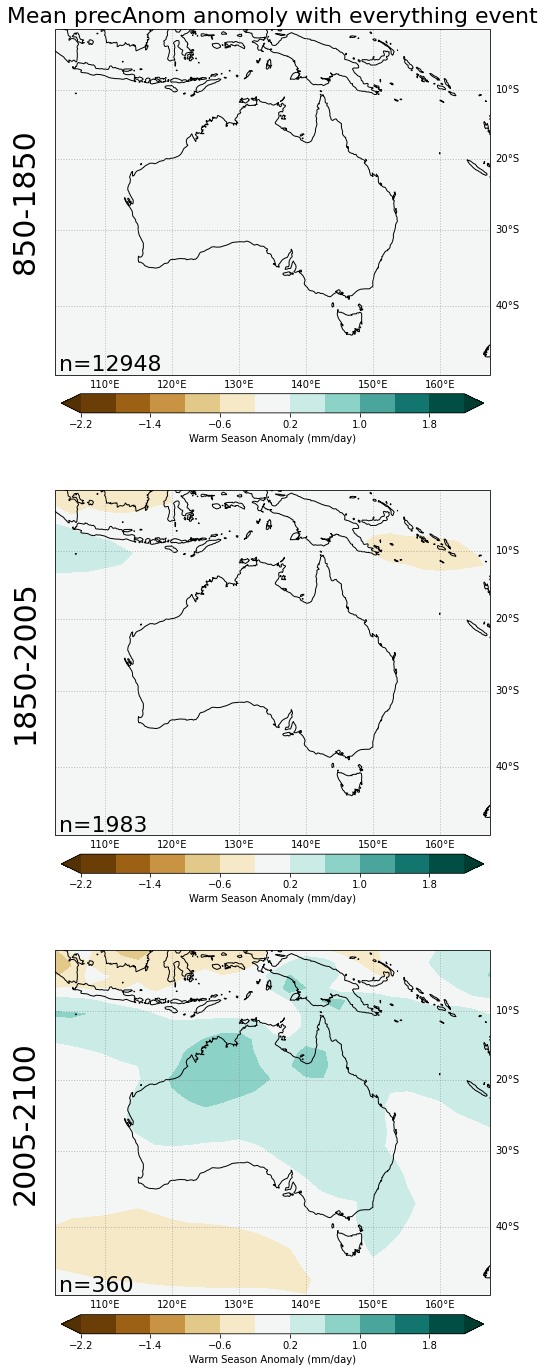

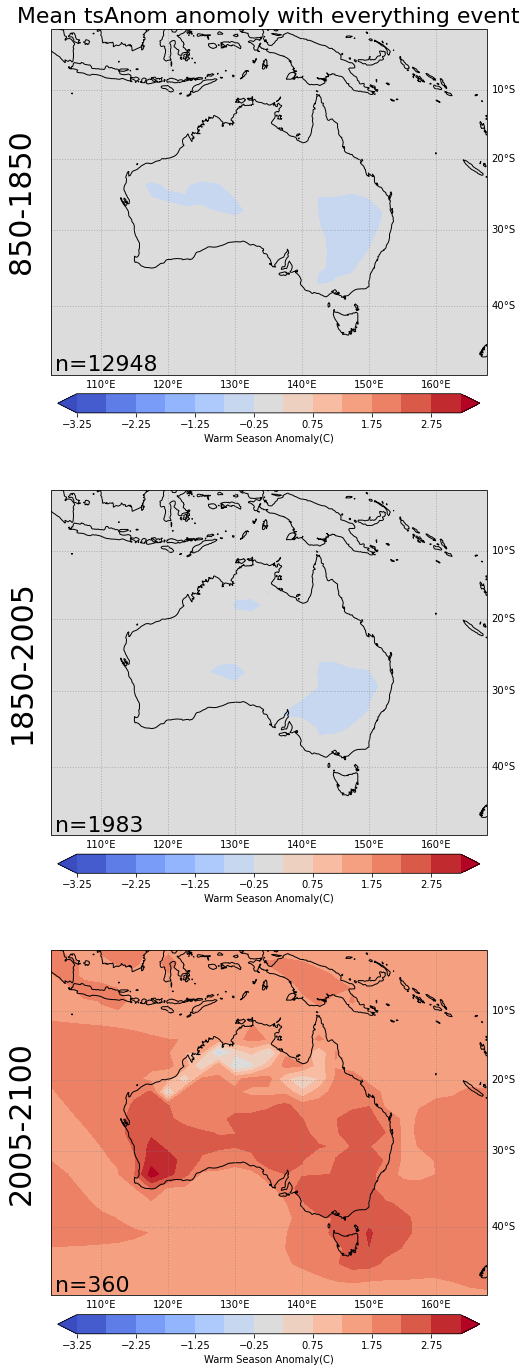

In [10]:
multiPlotter(
    rainfallXr.precAnom.rolling(year=11, center=True).mean('year'), 
    everythingXr.to_dataset(), 
    ['everything'],
    'results/cesmImpactFigures/firePosPrecTrend.png'
)

multiPlotter(
    tempXr.tsAnom.rolling(year=11, center=True).mean('year'), 
    everythingXr.to_dataset(), 
    ['everything'],
    'results/cesmImpactFigures/firePosTempTrend.png'
)

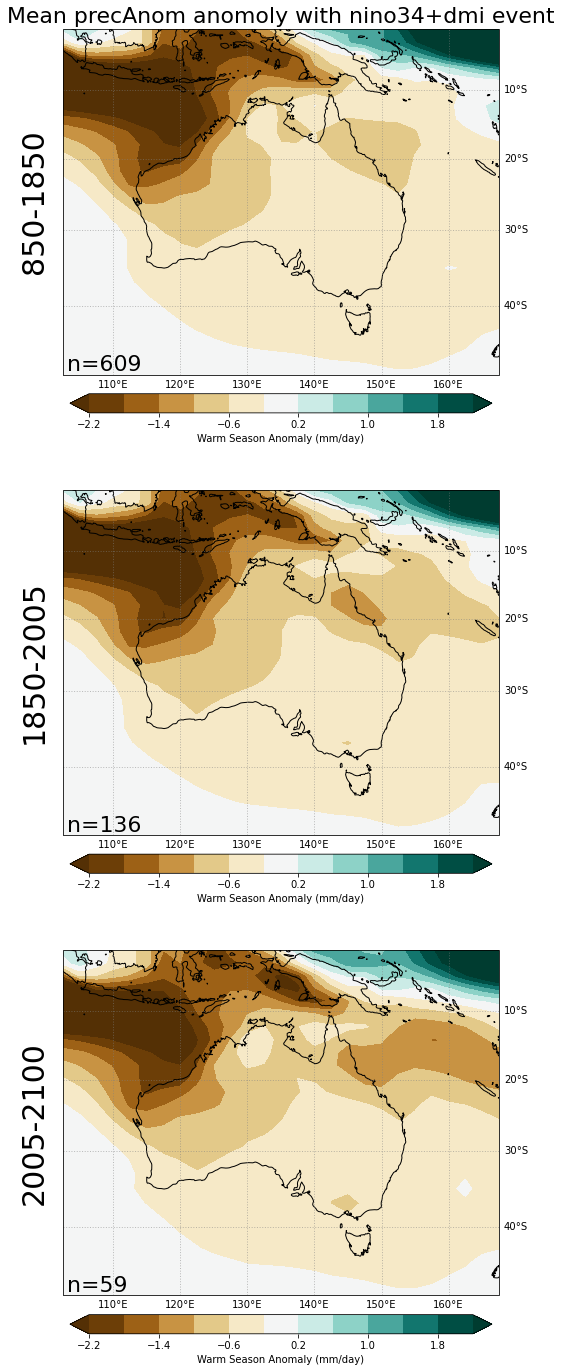

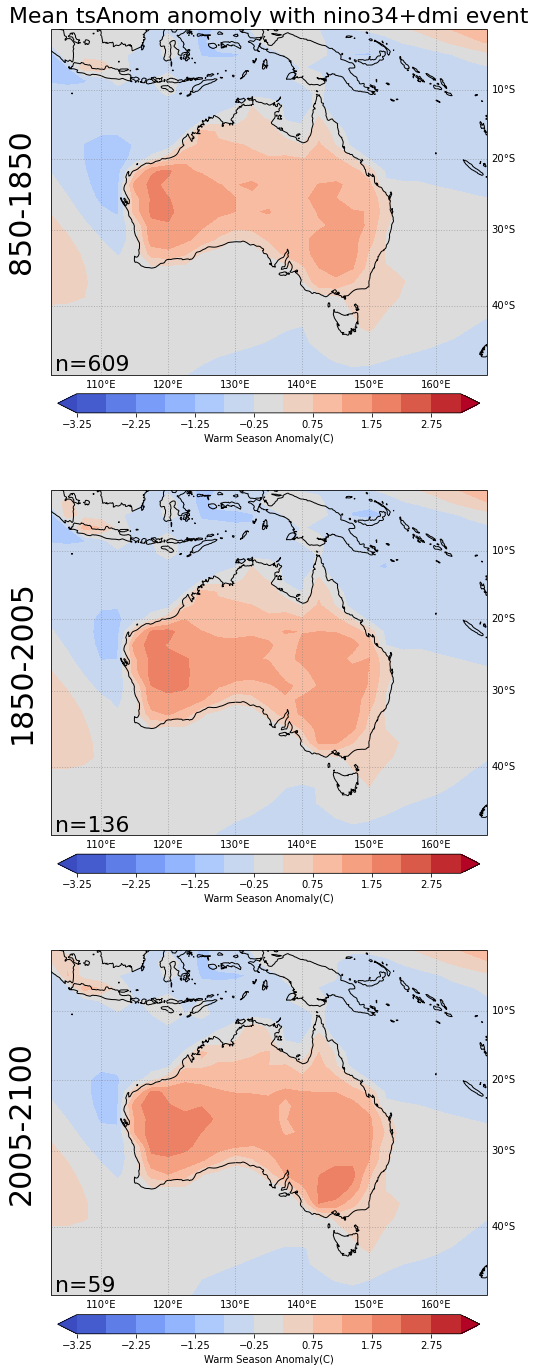

In [11]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    ['nino34+dmi'],
    'results/cesmImpactFigures/firePosPrecDetrend.png'
)


multiPlotter(
    tempXr.tsAnom-tempXr.tsAnom.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    ['nino34+dmi'], 
    'results/cesmImpactFigures/firePosTempDetrend.png'
)

Justification for 11 year rolling av

In [12]:
bestFit = numpy.polyfit(x=rainfallXr.year, y=rainfallXr.precAnom.mean(['experiment', 'lat', 'lon']),deg=5)
p = numpy.poly1d(bestFit)

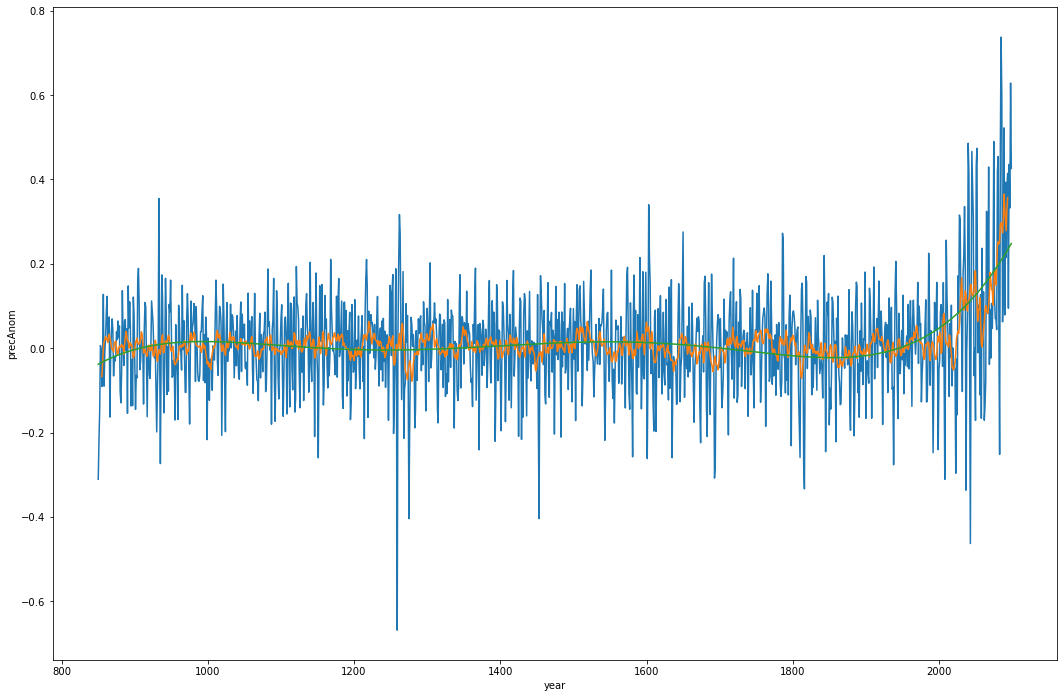

In [13]:
plt.figure(figsize=(18,12))
rainfallXr.precAnom.mean(['experiment', 'lat', 'lon']).plot()
rainfallXr.precAnom.rolling(year=11, center=True).mean('year').mean(['experiment', 'lat', 'lon']).plot()
plt.plot(rainfallXr.year, p(rainfallXr.year))

<xarray.DataArray 'precAnom' ()>
array(0.11270442)

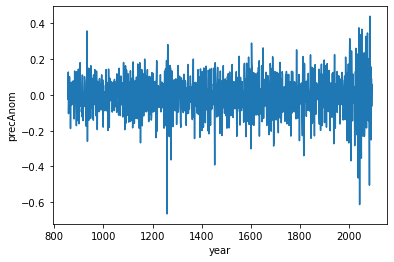

In [14]:
(rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=11, center=True).mean('year')
    ).mean(['experiment','lat','lon']).plot()
(rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=11, center=True).mean('year')
    ).mean(['experiment','lat','lon']).std()

<xarray.DataArray 'precAnom' ()>
array(0.11325313)

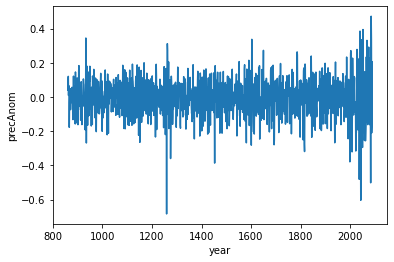

In [15]:
(rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=21, center=True).mean('year')
    ).mean(['experiment','lat','lon']).plot()
(rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=21, center=True).mean('year')
    ).mean(['experiment','lat','lon']).std()

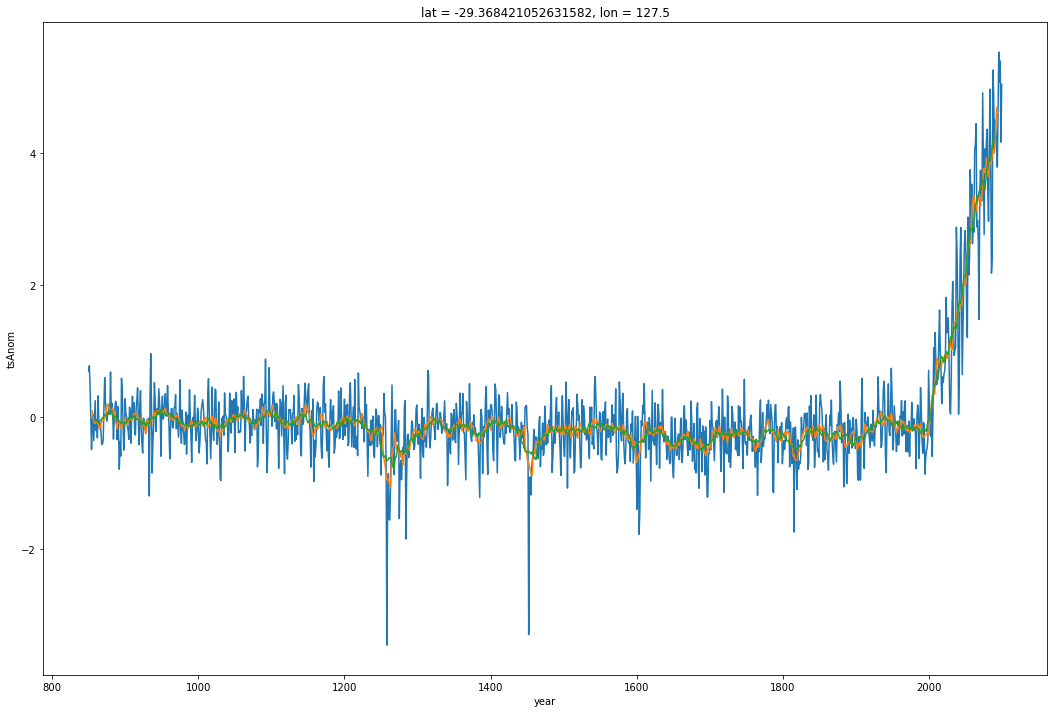

In [16]:
plt.figure(figsize=(18,12))
tempXr.tsAnom.isel(lat=10,lon=10).mean('experiment').plot()
tempXr.tsAnom.rolling(year=11, center=True).mean('year').isel(lat=10,lon=10).mean('experiment').plot()
tempXr.tsAnom.rolling(year=21, center=True).mean('year').isel(lat=10,lon=10).mean('experiment').plot()


# And again for Fire Neg

In [17]:
everythingXr=(fireNeg.nEvents<5)
everythingXr.name='everything'

noEventXr=(fireNeg.nEvents==0)
noEventXr.name='noFireNeg'

nothingXr=noEventXr&(firePos.nEvents==0)
nothingXr.name='no'

singleEventsXr=(fireNeg[fireNeg.indeces]==True)

compoundEventsXr=(fireNeg[[*fireNeg.pairs, 'all3']]==True)

maskXr=xarray.merge([everythingXr,nothingXr, noEventXr, singleEventsXr, compoundEventsXr])

eventsList=['everything','no', 'noFireNeg', *fireNeg.indeces, *fireNeg.pairs, 'all3']

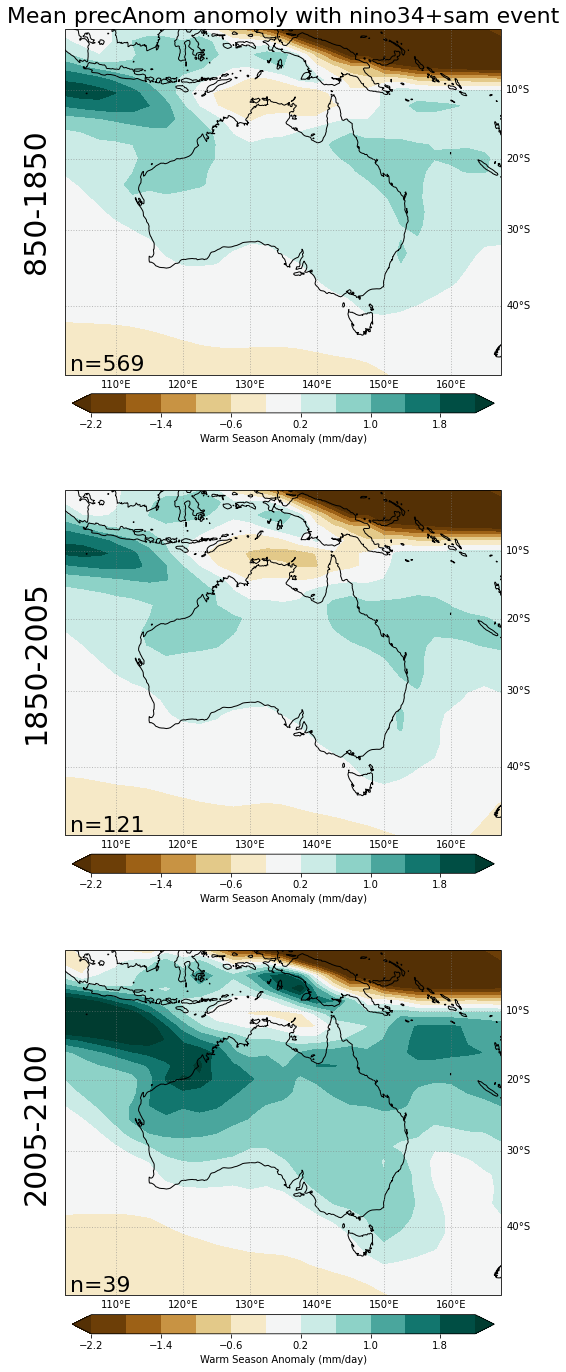

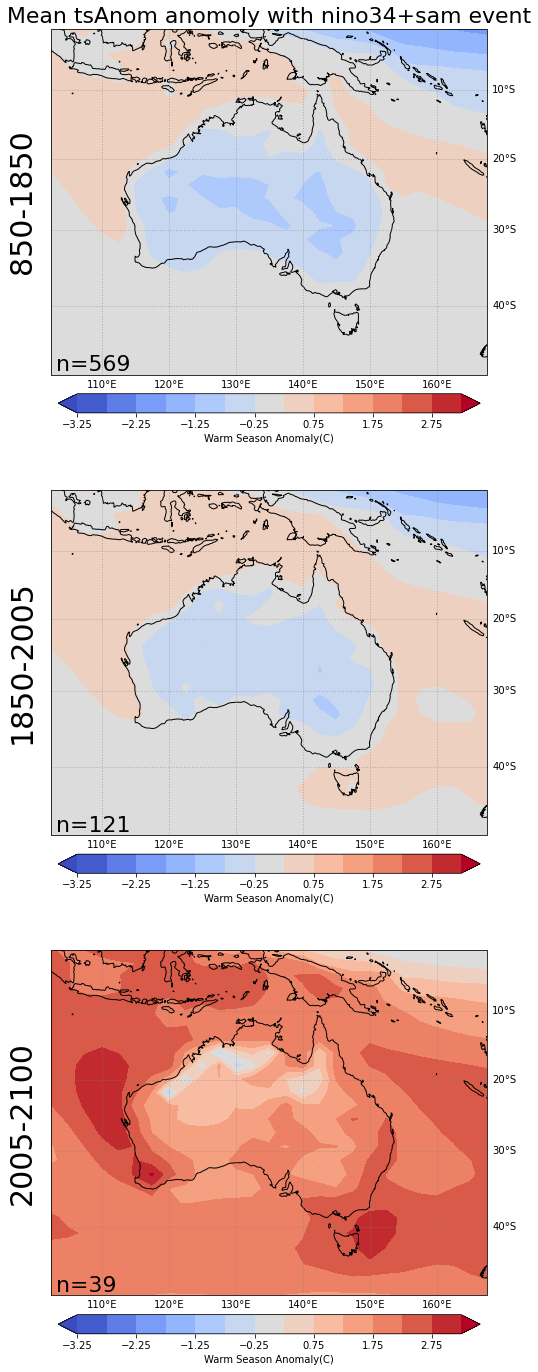

In [18]:
multiPlotter(
    rainfallXr.precAnom, 
    maskXr, 
    ['nino34+sam'],
    'results/cesmImpactFigures/fireNegPrec.png'
)


multiPlotter(
    tempXr.tsAnom, 
    maskXr, 
    ['nino34+sam'], 
    'results/cesmImpactFigures/fireNegTemp.png'
)

And detrended

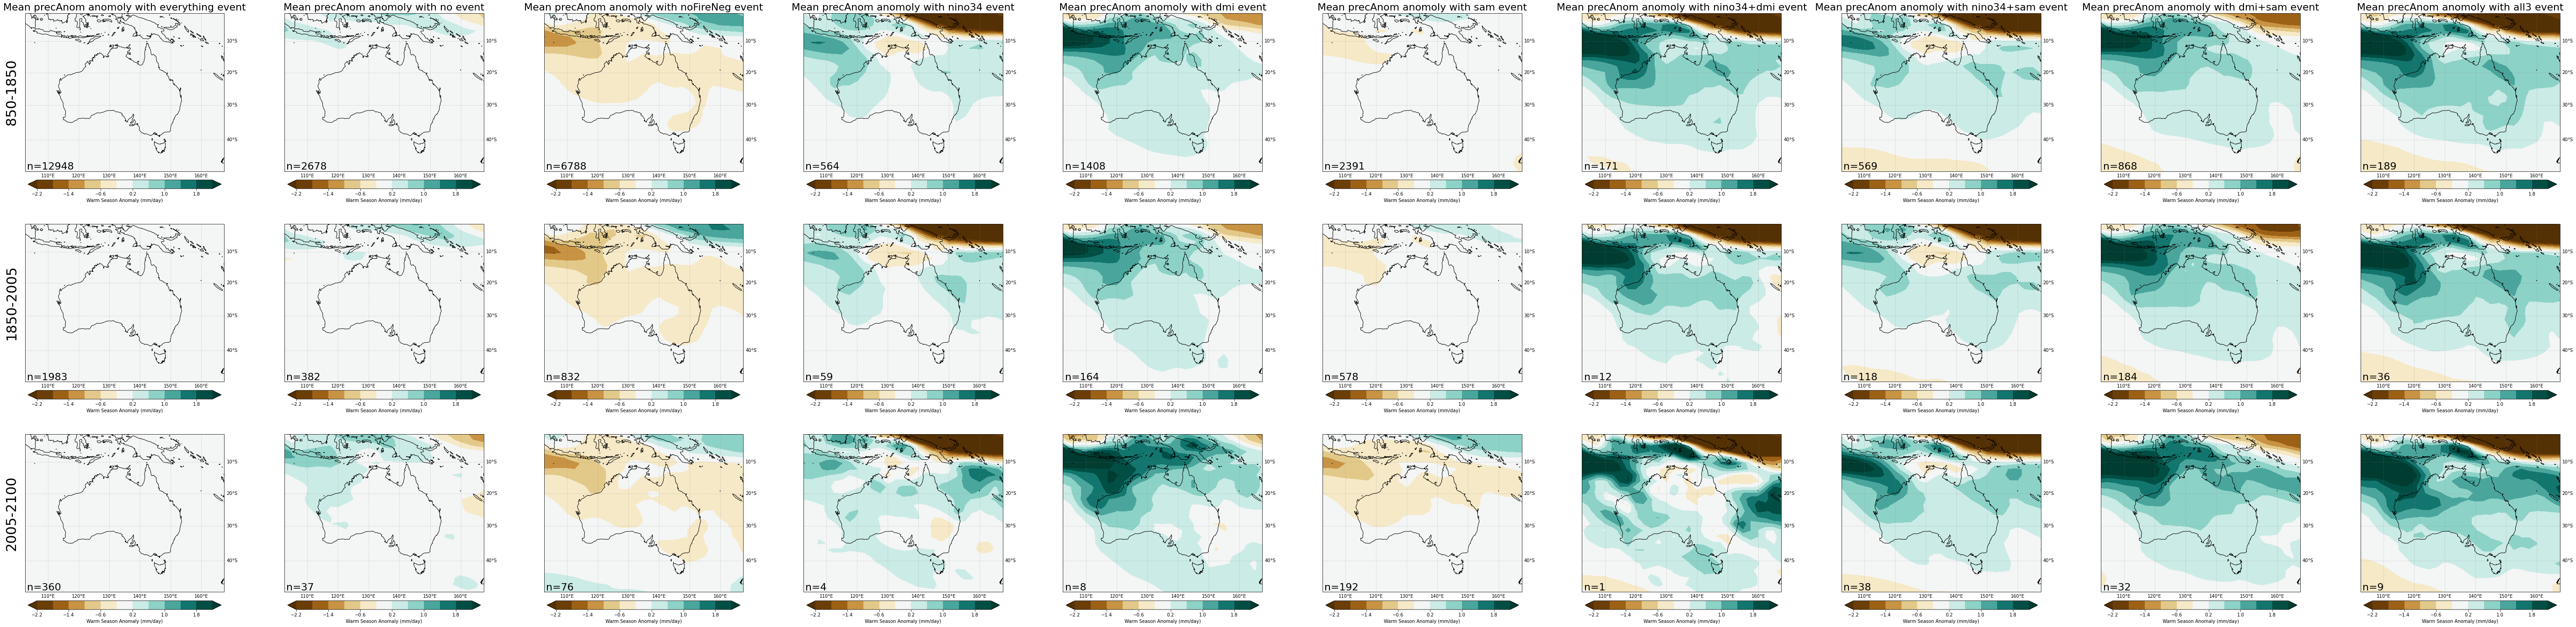

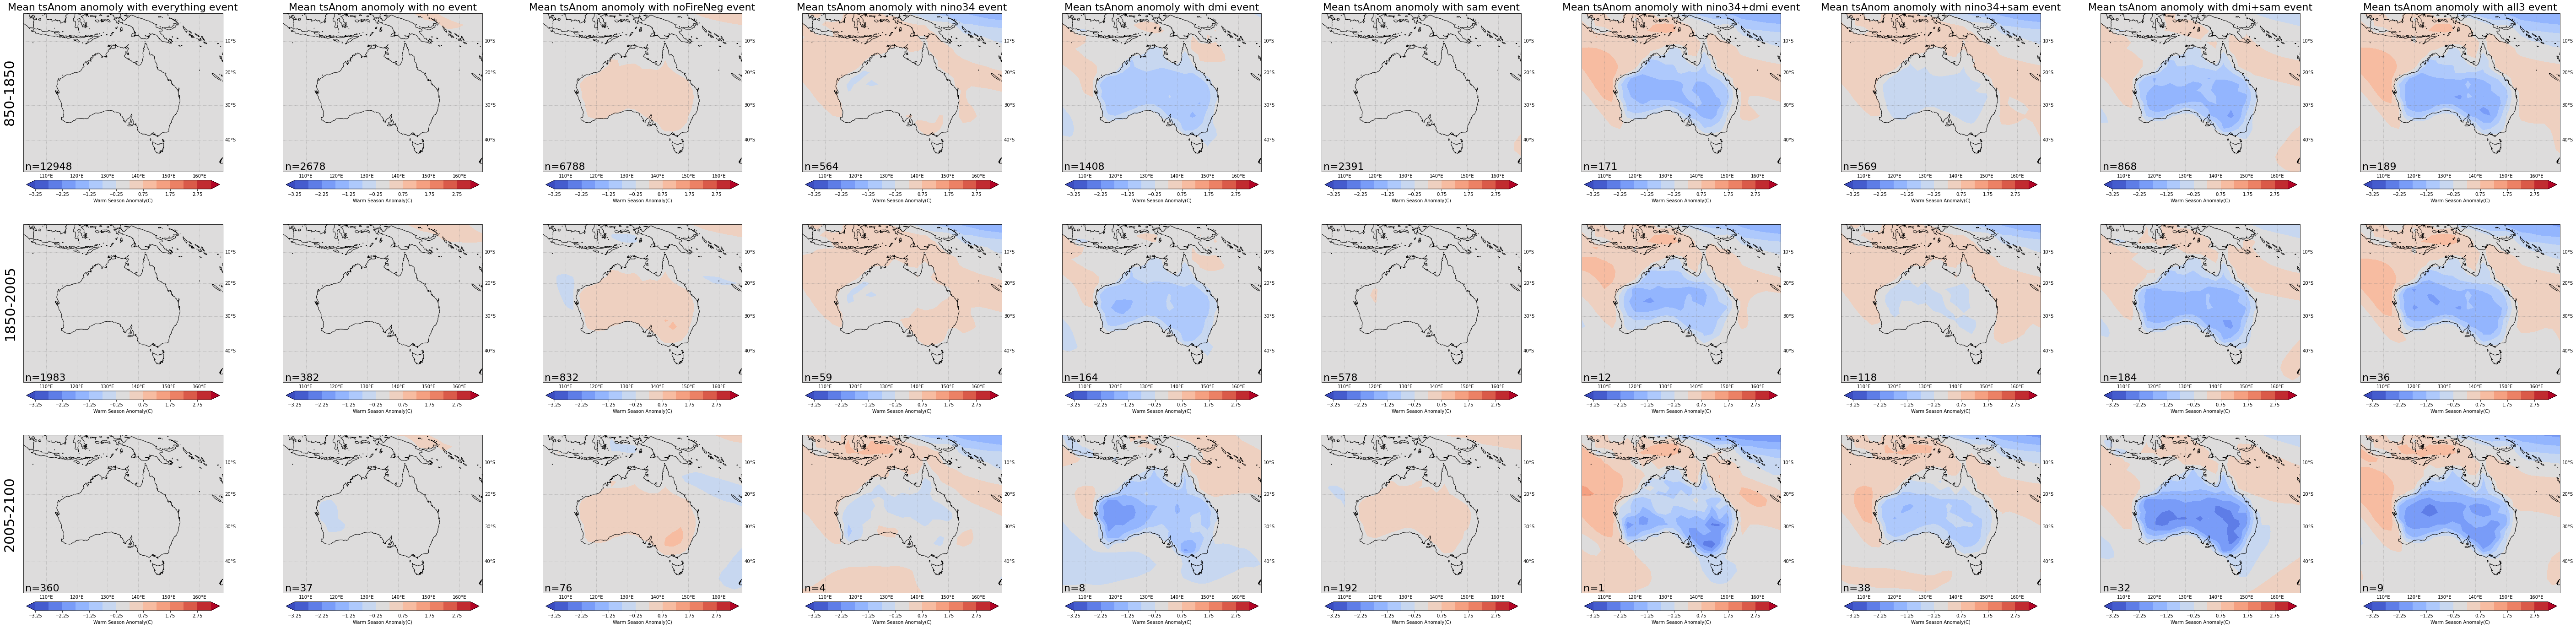

In [19]:
# rainfall plots, fire Pos
multiPlotter(
    rainfallXr.precAnom-rainfallXr.precAnom.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList,
    'results/cesmImpactFigures/fireNegPrecDetrend.png'
)


multiPlotter(
    tempXr.tsAnom-tempXr.tsAnom.rolling(year=11, center=True).mean('year'), 
    maskXr, 
    eventsList, 
    'results/cesmImpactFigures/fireNegTempDetrend.png'
)